In [1]:
import numpy as np
import pandas as pd
from utils.dataPreprocessing import  data_preprocessing
from utils.dataVisualisation import plot_grid_search
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, GridSearchCV

### 1. Data preparation

In [2]:
df_data = pd.read_csv('../data/train.csv')
df_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [3]:
X, t = data_preprocessing(df_data, normalized=True, one_hot=False)
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)

In [4]:
#creation of lists of possible hyper-parameter values and choice of maximum number of iterations
all_values_lr = np.logspace(-9, 0, 10)
all_values_alpha = np.logspace(-9, 0, 10)
max_iter = 10000

### 2. Perceptron without parameter optimisation and regularization

In [5]:
# creation of a multiclass perceptron classifier
classifieur_perceptron = Perceptron(alpha =0, eta0= 0.001, penalty=None, random_state=0)   
classifieur_perceptron.fit(X_train, t_train)

Perceptron(alpha=0, eta0=0.001)

In [6]:
print("Accuracy X_train, t_train : {:.2f}%".format(classifieur_perceptron.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(classifieur_perceptron.score(X_test, t_test)*100))

Accuracy X_train, t_train : 97.84%
Accuracy X_test, t_test : 88.89%


### 3. Perceptron without parameter optimisation with L2 penalty

In [7]:
classifieur_reg = Perceptron(penalty='l2')    
classifieur_reg.fit(X_train, t_train)

Perceptron(penalty='l2')

In [8]:
print("Accuracy X_train, t_train : {:.2f}%".format(classifieur_reg.score(X_train, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(classifieur_reg.score(X_test, t_test)*100))

Accuracy X_train, t_train : 91.63%
Accuracy X_test, t_test : 86.53%


### 4. Perceptron with parameter optimization

In [9]:
#Parameters to be tested
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Creation of the grid search model
grid_search_perceptron = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
grid_search_perceptron.fit(X_train, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [10]:
results_grid_perceptron = pd.DataFrame.from_dict(grid_search_perceptron.cv_results_)

In [11]:
print("Best parameters:", grid_search_perceptron.best_params_)
print("Best accuracy on a split : {:.2f}%".format(grid_search_perceptron.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(grid_search_perceptron.score(X_train, t_train)*100))

Best parameters: {'alpha': 1e-09, 'eta0': 1.0}
Best accuracy on a split : 90.33%
Accuracy X_train, t_train : 100.00%


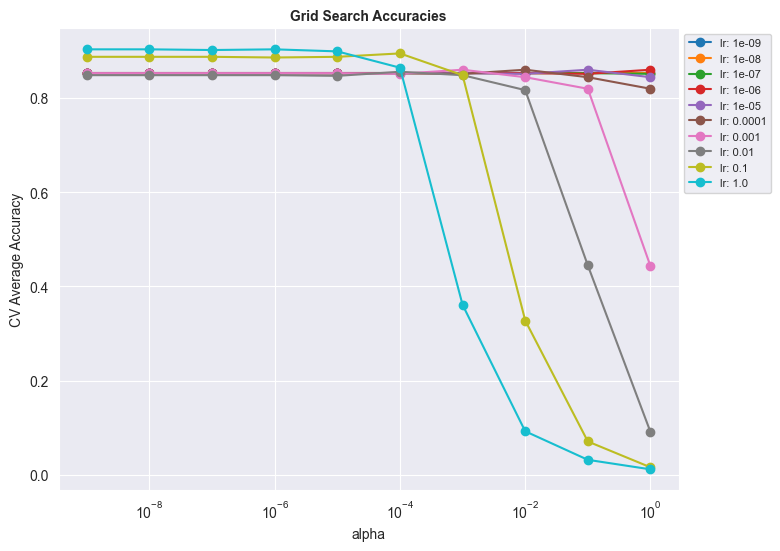

In [12]:
plot_grid_search(results_grid_perceptron, all_values_lr, all_values_alpha,'lr','alpha',axis=0)

### 6. Testing the perceptron on our test data

In [15]:
print("Accuracy X_test, t_test : {:.2f}%".format(grid_search_perceptron.score(X_test, t_test)*100))

Accuracy X_test, t_test : 93.27%


### 7. Use a perceptron to isolate each feature: Margin / Shape / Texture
### 7.1 Preparing the data

### 5. Visualization of the evolution of our accuracy according to the evolution of our hyper-parameters

In [16]:
X_train_margin = X_train[:,:64]
X_test_margin = X_test[:,:64]

In [17]:
X_train_shape = X_train[:,64:128]
X_test_shape = X_test[:,64:128]

In [18]:
X_train_texture = X_train[:,128:]
X_test_texture = X_test[:,128:]

### 7.2 Finding the best model for each feature
### 7.2.1 Margin :

In [19]:
# Parameters to be tested
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Creation of the grid search model
perceptron_margin = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
perceptron_margin.fit(X_train_margin, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [20]:
print("Best parameters :", perceptron_margin.best_params_)
print("Best accuracy on a split : {:.2f}%".format(perceptron_margin.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(perceptron_margin.score(X_train_margin, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(perceptron_margin.score(X_test_margin, t_test)*100))

Best parameters : {'alpha': 1e-06, 'eta0': 1.0}
Best accuracy on a split : 54.69%
Accuracy X_train, t_train : 80.23%
Accuracy X_test, t_test : 50.84%


### 7.2.2 Shape : 

In [21]:
# Parameters to be tested
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Creation of the grid search model
perceptron_shape = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
perceptron_shape.fit(X_train_shape, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [22]:
print("Best parameters :", perceptron_shape.best_params_)
print("Best accuracy on a split : {:.2f}%".format(perceptron_shape.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(perceptron_shape.score(X_train_shape, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(perceptron_shape.score(X_test_shape, t_test)*100))

Best parameters : {'alpha': 1e-05, 'eta0': 1.0}
Best accuracy on a split : 10.97%
Accuracy X_train, t_train : 8.95%
Accuracy X_test, t_test : 8.42%


### 7.2.3 Texture : 

In [23]:
# Parameters to be tested
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Creation of the grid search model
perceptron_texture = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
perceptron_texture.fit(X_train_texture, t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [24]:
print("Best parameters :", perceptron_texture.best_params_)
print("Best accuracy on a split : {:.2f}%".format(perceptron_texture.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(perceptron_texture.score(X_train_texture, t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(perceptron_texture.score(X_test_texture, t_test)*100))

Best parameters : {'alpha': 1e-07, 'eta0': 1.0}
Best accuracy on a split : 58.44%
Accuracy X_train, t_train : 76.62%
Accuracy X_test, t_test : 57.58%


### Margin and Texture

In [25]:
# Parameters to be tested
param_grid_perceptron = {
    'eta0' : all_values_lr,
    'alpha' : all_values_alpha
}

# Creation of the grid search model
perceptron_texture = GridSearchCV(Perceptron(penalty='l2', max_iter=max_iter), param_grid_perceptron, cv=3, verbose=3, n_jobs=-1)

# Training the model with grid search
perceptron_texture.fit(np.hstack((X_train_margin, X_train_texture)), t_train)
print('Done')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Done


In [26]:
print("Best parameters :", perceptron_texture.best_params_)
print("Best accuracy on a split : {:.2f}%".format(perceptron_texture.best_score_*100))
print("Accuracy X_train, t_train : {:.2f}%".format(perceptron_texture.score(np.hstack((X_train_margin, X_train_texture)), t_train)*100))
print("Accuracy X_test, t_test : {:.2f}%".format(perceptron_texture.score(np.hstack((X_test_margin, X_test_texture)), t_test)*100))

Best parameters : {'alpha': 1e-09, 'eta0': 1.0}
Best accuracy on a split : 86.44%
Accuracy X_train, t_train : 99.86%
Accuracy X_test, t_test : 85.86%
